Attempt of Implementation of the ACE algorithm for the fast implementation of the article 2

### Imports

In [9]:
import numpy as np
import platform
import tempfile
import os
import math
import matplotlib.pyplot as plt
from scipy.fftpack import idct,dct
from skimage import io as skio
import skimage

import cv2

### Auxiliar Functions

In [2]:
#Function to read an image from the disk
def read_image(image_path, color_espace = ''):
    """
    Read an image from the disk.
    :param image_path: The path to the image.
    :param color_espace: The color espace to convert the image.
    :return: The image.
    """
    # Load the image
    image = skio.imread(image_path)
    #For color images
    if len(image.shape) == 3:
        # Convert the image to the RGB color space
        image = cv2.imread(image_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if color_espace == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        elif color_espace == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_espace == 'LAB':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        elif color_espace == 'GRAY':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        

    # Return the image
    return image

#### Chromatic/ Spatial Adjustment

In [43]:
def distance(p, q, type):
  if type == "euclidian":
    return math.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)
  elif type == "manhattan":
    return abs(p[0]-q[0]) + abs(p[1]-q[1])
  elif type == "maximal":
    return max(abs(p[0]-q[0]), abs(p[1]-q[1]))
  elif type == "inverse_exponential":
    return 1/(math.dist(p, q))
  
  return math.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)


#calculate W
def distance_w(img):
  height = img.shape[0]
  width = img.shape[1]
  sum = 0
  w = np.zeros(( img.shape[0],img.shape[1] ))
  
  for x in range(w.shape[0]):
    for y in range(w.shape[1]):
      if x==0 and y==0:
        w[x,y] = 0
      else :
        w[x,y] = 1/np.sqrt(x**2 + y**2)

      sum += w[x,y]

  return w/sum

#DCT of image
def dct2D(I, type):
  return dct(dct(I,type=type, axis=0, norm='ortho'),type=type, axis=1, norm='ortho')

#IDCT of image
def idct2D(I, type):
  return idct(idct(I,type=type, axis=0, norm='ortho'),type=type, axis=1, norm='ortho')

#Calculate convolution
def convolution(w, I):
  return idct2D((dct2D(w,type=1)*dct2D(I,type=2)),type=2)

#Calculate potence
def potence(I, n):
  return I**n


#Slope Coefficient
SlopeCoeff = [
    [1.0, 0, 0, 0, 0],                                                    # Alpha = 1
    [1.85623249, 3.82397125, -19.70879455, 26.15510902, -11.15375327],    # Alpha = 2
    [3.51036396, -6.31644952, 0.92439798, 9.32834829, -6.50264005],       # Alpha = 3
    [4.76270090, -18.23743983, 36.10529118, -31.35677926, 9.66532431],    # Alpha = 4
    [5.64305564, -28.94026159, 74.52401661, -83.54012582, 33.39343065],   # Alpha = 5
    [6.19837979, -35.18789052, 95.28157108, -109.95601312, 44.78177264],  # Alpha = 6
    [6.69888108, -41.02503190, 115.02784036, -135.35603880, 55.81014424], # Alpha = 7
    [7.15179080, -46.43557440, 133.54648929, -159.34156394, 66.27157886]  # Alpha = 8
]


#ACE
def ace(I_original, alpha, degree):
  
  #final image
  o = np.zeros_like(I_original)

  pow = [1,3,5,7,9]

  #Calculate the W
  w = distance_w(I_original)

  #Calculate the ACE
  if I_original.ndim == 2:
    I = I_original
    for i in range(5):
        a_n = SlopeCoeff[alpha-1][i]
        conv = convolution(w, potence(I, pow[i]))
        
        for x in range(conv.shape[0]):
          for y in range(conv.shape[1]):
            o[x,y] += a_n*conv[x,y]
       
    return o
  else:
    for channel in range(3):
        channel_o = o[:, :, channel]
        I = I_original[:, :, channel]
      
        for i in range(5):
          a_n = SlopeCoeff[alpha-1][i]
          conv = convolution(w, potence(I, pow[i]))
          
          for x in range(conv.shape[0]):
            for y in range(conv.shape[1]):
              channel_o[x,y] += a_n*conv[x,y]
        
        o[:, :, channel] = channel_o
        
    return o

folder = 'images/'
image = 'lena.tif'

color_espace = 'GRAY'
I_original = read_image(folder + image)

o = ace(I_original, 8, 9)

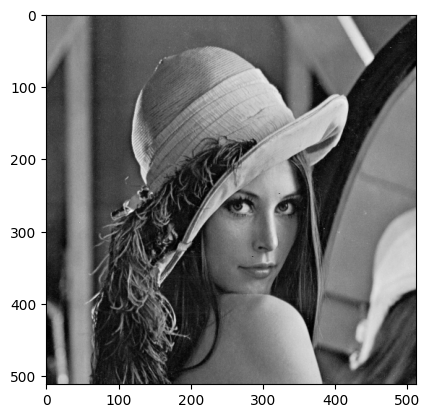

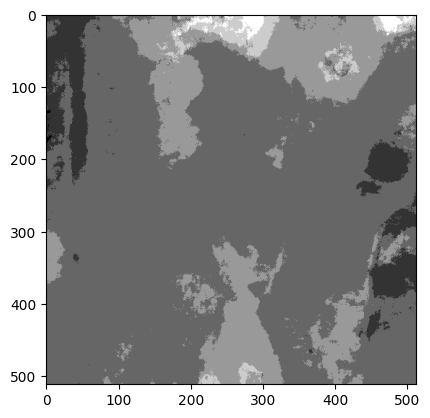

In [44]:
plt.imshow(I_original, cmap ="gray")
plt.show()

plt.imshow(o, cmap ="gray")
plt.show()

#### Dynamic Tone Reproduction Scaling

In [45]:
def dynamic_tone_reproduction_scaling (R,type):
  min_pixel = 255
  max_pixel = 0

  for raw in R:
    for pixel in raw:
      if pixel < min_pixel:
        min_pixel = pixel
      if pixel > max_pixel:
        max_pixel = pixel
  mc = min_pixel
  Mc = max_pixel
  sc = 255 / (Mc - mc)

  (y,x)=R.shape
  O = np.zeros((y,x))

  if type == "white_patch" :
    for i in range(y):
      for j in range(x):
        O[i,j] = round((127.5 + sc*R[i,j]))
  else :
    for i in range(y):
      for j in range(x):
        O[i,j] = round((sc*(R[i,j]- mc)))

  return O
  
def dynamic_tone_reproduction(R,type, color_espace):
  if color_espace == 'RGB':
    (x,y, color)=R.shape
    O = np.zeros((x,y, color))

    for color in range(R.shape[2]):
      O[:,:,color] = dynamic_tone_reproduction_scaling(R[:,:,color],type)
      
  else:
    (x,y)=R.shape
    O = np.zeros((x,y))
    O = dynamic_tone_reproduction_scaling(R,type)

  return O


#### Results

In [52]:
def show_results(I,R,O, image=None, color_espace=None):
  fig, axs = plt.subplots(1, 3, figsize=(12, 4))
  axs[0].axis("off")
  axs[0].imshow(I, cmap ="gray")
  axs[0].set_title('Original')
  axs[1].axis("off")
  axs[1].imshow(R, cmap ="gray")
  axs[1].set_title('Intermediate')
  axs[2].axis("off")
  axs[2].imshow(O, cmap ="gray")
  axs[2].set_title('Output')

  if color_espace:
    # Agregar un título común para los tres subplots
    fig.suptitle(image + ' in color espace: '+color_espace, fontsize=16)
    plt.savefig('test/'+image+'_'+color_espace+'.png')

  plt.show()

  

In [54]:
def convert_to_rgb_from_HSV(original, processed):
    hue_channel = original[:,:,0]
    saturation_channel = original[:,:,1]
    value_channel = processed

    image_hsv = np.zeros(original.shape)

    image_hsv[:,:,0] = hue_channel
    image_hsv[:,:,1] = saturation_channel
    image_hsv[:,:,2] = value_channel

    # Asegúrate de que la imagen en HSV tenga un tipo de datos válido (CV_8U)
    image_hsv = cv2.convertScaleAbs(image_hsv)

    return cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)

def convert_to_rgb_from_LAB(original, processed):
    l_channel = processed
    a_channel = original[:,:,1]
    b_channel = original[:,:,1]

    image_lab = np.zeros(original.shape)

    image_lab[:,:,0] = l_channel
    image_lab[:,:,1] = a_channel
    image_lab[:,:,2] = b_channel

    # Asegúrate de que la imagen en lab tenga un tipo de datos válido (CV_8U)
    image_lab = cv2.convertScaleAbs(image_lab)

    return cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)

#### Test

In [55]:
#Function to calculate histogram
def calculate_histogram(image):
    hist = []
    if len(image.shape) == 3:
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    else:
        hist, bin_edges = np.histogram(image, bins=256)    
    return hist

def calculate_percentage_color(hist):
    threshold = 127
    values_used = sum(1 for value in hist if value > 0)
    percentage_used_dynamic = (values_used / 256) * 100

    # Count the number of unused values in the black and white parts
    black_part = hist[:threshold]
    white_part = hist[threshold:]

    unused_black = len(black_part) - np.count_nonzero(black_part)
    unused_white = len(white_part) - np.count_nonzero(white_part)

    # Calculate the percentage of unused values
    total_black_values = len(black_part)
    total_white_values = len(white_part)

    percentage_unused_black = (unused_black / total_black_values) * 100
    percentage_unused_white = (unused_white / total_white_values) * 100

    return percentage_used_dynamic, percentage_unused_black, percentage_unused_white




In [56]:
def calculate_estatistics(I,R,O):
# Calculate the histogram of the original image
    hist_I = calculate_histogram(I)
    hist_R = calculate_histogram(R)
    hist_O = calculate_histogram(O)


    # Calculate the percentage of color used in the 3 images
    percentage_used_dynamic_I, percentage_unused_black_I, percentage_unused_white_I = calculate_percentage_color(hist_I)
    percentage_used_dynamic_R, percentage_unused_black_R, percentage_unused_white_R = calculate_percentage_color(hist_R)
    percentage_used_dynamic_O, percentage_unused_black_O, percentage_unused_white_O = calculate_percentage_color(hist_O)
    
    data = [[I.mean(), R.mean() , O.mean()],
        [I.std(), R.std() , O.std()],
        [np.var(hist_I),np.var(hist_R),np.var(hist_O)],
        [percentage_used_dynamic_I,percentage_used_dynamic_R,percentage_used_dynamic_O],
        [percentage_unused_black_I,percentage_unused_black_R,percentage_unused_black_O],
        [percentage_unused_white_I,percentage_unused_white_R,percentage_unused_white_O]]
    
    columns = ('Orig', 'Intermediate', 'ACE')
    rows = ['Mean', 'Std Dev' ,'Histogram Flatness', 'Percentage used dynamic', 'Percentage unused Black', 'Percentage unused White']

    return data,columns,rows

In [57]:
def show_histograms(I,R,O):
    # Calculate the histogram of the original image
    hist_I = calculate_histogram(I)
    hist_R = calculate_histogram(R)
    hist_O = calculate_histogram(O)
    
    pixels = list(range(256))

    # Get the values of the histogram
    hist_values_I = [int(hist) for hist in hist_I]
    hist_values_R = [int(hist) for hist in hist_R]
    hist_values_O = [int(hist) for hist in hist_O]

    fig, axs = plt.subplots(3, 1)

    fig.set_figheight(15)
    fig.set_figwidth(15)

    #Change 
    axs[0].bar(pixels, hist_values_I, width=1.0)
    axs[0].set_title('Original')

    axs[1].bar(pixels, hist_values_R, width=1.0)
    axs[1].set_title('Intermediate')

    axs[2].bar(pixels, hist_values_O, width=1.0)
    axs[2].set_title('Output')

    plt.show()

In [58]:
def show_table(I,R,O):
    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    data,columns, rows = calculate_estatistics(I,R,O) 

    ax.table(cellText=data,
            rowLabels=rows,
            colLabels=columns,
            loc='center')


    fig.tight_layout()

    plt.show()

In [62]:
def calculateColorConstancy(I1 , I2):
  Emean = 1
  Edelta = 0

  if I1.shape == I2.shape :
    (sizex,sizey)=I1.shape

    for x in range(sizex):
      for y in range(sizey):
        Edelta += I1[x,y] - I2[x,y]

    Emean = Edelta / (sizey*sizex)
  return Emean

### Get the Image

In [14]:
# folder = 'images/'
# image = 'bridge_test.png'

folder = 'images_paper/'
image = 'room_Ligth_A.png'

# folder = 'images_uea/catsi_dataset_c1_a/'
# image = 'img01_c1_a.tif'

# folder = 'images_uea/catsi_dataset_c1_d65/'
# image = 'img01_c1_d65.tif'

# folder = 'images_uea/catsi_dataset_c1_tl84/'
# image = 'img01_c1_tl84.tif'

color_espace = 'RGB'

### Implementation

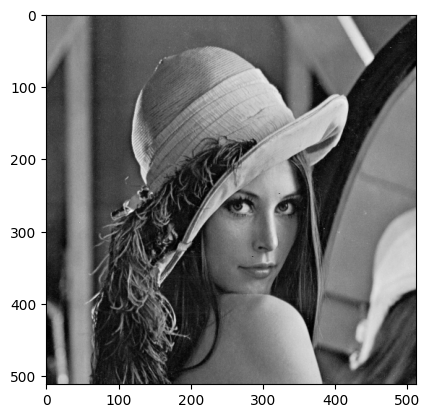

In [46]:
I_original = read_image(folder + image)
plt.imshow(I_original, cmap ="gray")
plt.show()

#to get the 3 channels
if len(I_original.shape) == 3:
    I_color_espace = read_image(folder + image , color_espace)
    
    plt.imshow(I_color_espace, cmap ="gray")
    plt.show()

In [48]:
if(len(I_original.shape) == 3):
    if color_espace == 'HSV':
        hue_channel = I_color_espace[:,:,0]
        saturation_channel = I_color_espace[:,:,1]
        value_channel = I_color_espace[:,:,2]

        I = value_channel
    elif color_espace == 'LAB':
        l_channel = I_color_espace[:,:,0]  # Canal L*
        a_channel = I_color_espace[:,:,1]  # Canal a*
        b_channel = I_color_espace[:,:,2]  # Canal b*

        I = l_channel
    elif color_espace == 'RGB':
        r_channel = I_color_espace[:,:,0]
        g_channel = I_color_espace[:,:,1]
        b_channel = I_color_espace[:,:,2]
        I = I_color_espace

else:
    I = I_original

In [47]:
I_original.shape

(512, 512)

#### Chromatic/ Spatial Adjustment

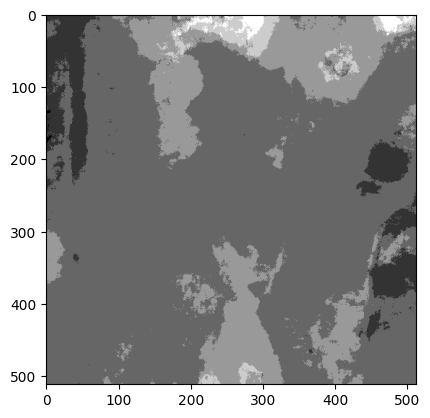

In [49]:
R = ace(I, 8, 9)
plt.imshow(R, cmap ="gray")
plt.show()

###### Chromatic/ Spatial Adjustment for RGB colors


Appliquer HSV (Hue,Saturation,Value) Seulement pour V

LAB (Luminosite, colorimetrie) 

Regarder chaque canaux

#### Dynamic Tone Reproduction Scaling

In [50]:
O = dynamic_tone_reproduction(R,"white_patch", color_espace)

#### Results

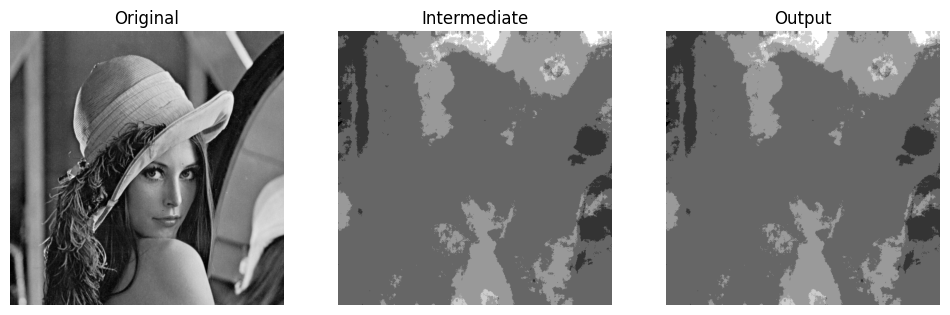

In [53]:
if color_espace == 'RGB':
    for color in range(I.shape[2]):
        show_results(I[:,:,color],R[:,:,color],O[:,:,color])
else : 
    show_results(I,R,O)

In [60]:
if(len(I_original.shape) == 3):
    if color_espace == 'HSV':
        R_rgb = convert_to_rgb_from_HSV(I_color_espace, R)
        O_rgb = convert_to_rgb_from_HSV(I_color_espace, O)
    elif color_espace == 'LAB':
        R_rgb = convert_to_rgb_from_LAB(I_color_espace, R)
        O_rgb = convert_to_rgb_from_LAB(I_color_espace, O) 
    elif color_espace == 'RGB':
        R_rgb = R
        O_rgb = cv2.convertScaleAbs(O)
    
    show_results(I_original,R_rgb,O_rgb, image, color_espace) 
    


#### Test

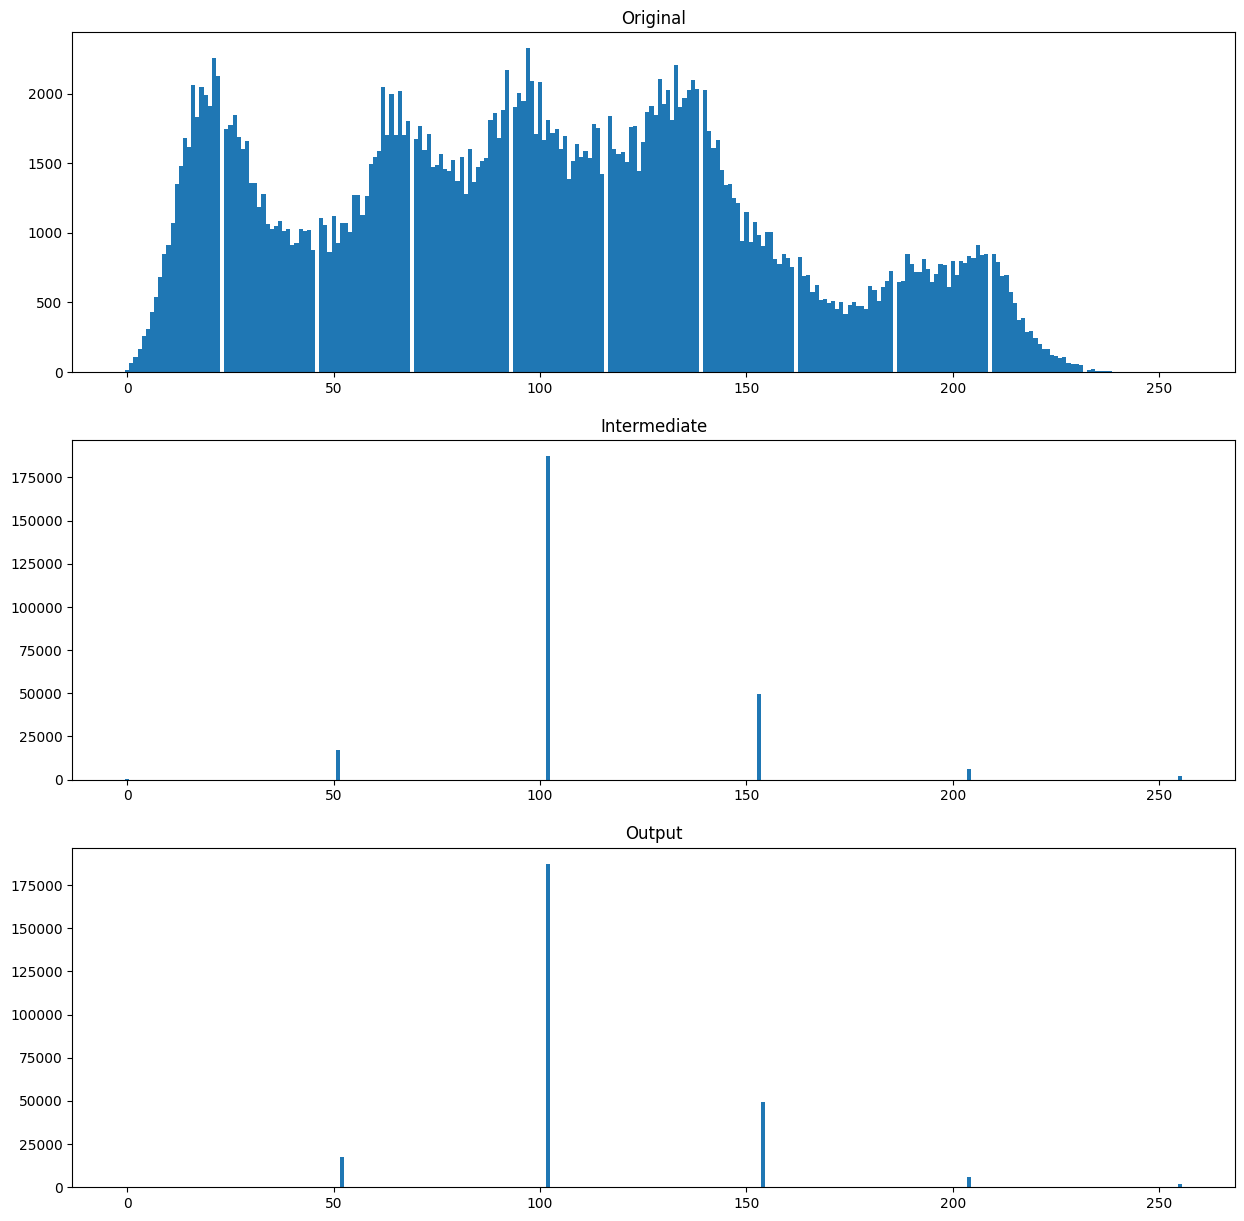

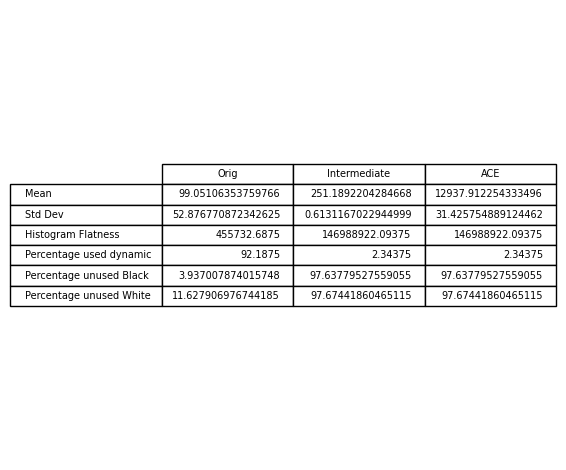

NameError: name 'color' is not defined

In [63]:
#calculate the histograms if the image is in color espace RGB
if color_espace == 'RGB':
    for color in range(I.shape[2]):
        # SHOW THE HISTOGRAMS
        show_histograms(I[:,:,color],R[:,:,color],O[:,:,color])
        # SHOW THE TABLE
        show_table(I[:,:,color],R[:,:,color],O[:,:,color])

        #SHOW THE COLOR CONSTANCY
        color_constancy = calculateColorConstancy(I[:,:,color],O[:,:,color])
        print(f"Color constancy for color channel {color} is : {color_constancy}", )
else:
    # SHOW THE HISTOGRAMS
    show_histograms(I,R,O)
    # SHOW THE TABLE
    show_table(I,R,O)

    #SHOW THE COLOR CONSTANCY
    color_constancy = calculateColorConstancy(I,O)
    print(f"Color constancy for color channel {color} is : {color_constancy}", )
   

## Code ends

In [ ]:
print(0)

0
